# Creating DC2 Templates

Loading Brown et al. templates with emission lines masked we will attempt to extrapolate in color space and create new templates that better span the color space of DC2 galaxies. To do the extrapolation we will use [ESP](https://github.com/jbkalmbach/ESP).

## Creating templates with LSST colors

CosmoDC2 comes with rest frame magnitudes in the LSST bands. We can use these to map out the color space and create new templates to better cover this color space.

In [1]:
import sys,os
sys.path.append('/global/homes/s/schmidt9/.local/lib/python3.6/site-packages/')

### Load templates and perform PCA

In [2]:
import esp
import numpy as np
import GCRCatalogs
from copy import deepcopy
from matplotlib import pyplot as plt
from lsst.sims.photUtils import BandpassDict, Bandpass, Sed
from sklearn.cluster import KMeans
%matplotlib inline

Here we load the Brown templates from the data directory. To get better coverage in the bluer edge of color space we also include "two single stellar population models with low/no dust and low metallicity that were used with BPZ for the HUDF to mimic super blue galaxies at z~5-7." (From Sam's comment [here](https://github.com/LSSTDESC/pz_pdf/issues/2)).

In [3]:
brown_data_dir = '../../data/galacticus_dust_templates/'
pca_obj = esp.pcaSED()
pca_obj.load_full_spectra(brown_data_dir)

File On 100 out of 893
File On 200 out of 893
File On 300 out of 893
File On 400 out of 893
File On 500 out of 893
File On 600 out of 893
File On 700 out of 893
File On 800 out of 893
Done loading spectra from file


In [4]:
new_spec_list = []
for sed_obj in pca_obj.spec_list_orig:
    new_sed_obj = deepcopy(sed_obj)
    new_sed_obj.wavelen = new_sed_obj.wavelen/10. #Convert to nanometers
    new_spec_list.append(new_sed_obj)
pca_obj.spec_list_orig = new_spec_list

Now we perform PCA on the templates truncating them at 1200.0 nanometers and keeping 10 components

In [5]:
pca_obj.PCA(minWavelen=1., maxWavelen=1200., comps=10)

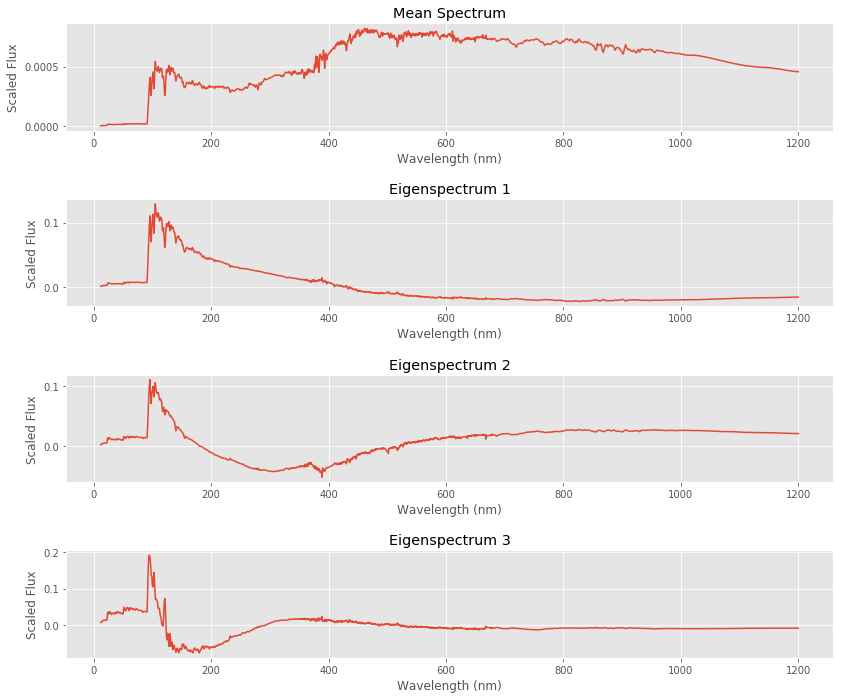

In [6]:
plotter = esp.plotUtils()
fig = plt.figure(figsize=(12, 10))
fig = plotter.plot_eigenspectra(pca_obj, 3, fig = fig)

In [7]:
### If there is already a folder for storing the PCA information uncomment below
#! rm -rf brown_pca

In [8]:
os.mkdir('galacticus_pca_wBC03_v4.0')
pca_obj.write_output('galacticus_pca_wBC03_v4.0')

In [9]:
print('The 10 eigenspectra explain %.4f percent of the variance in the input template set.' % (100*np.sum(pca_obj.exp_var)))

The 10 eigenspectra explain 98.8028 percent of the variance in the input template set.


### Load the DC2 data from `gcr_catalogs`

In [10]:
catalog = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_small')
#catalog = GCRCatalogs.load_catalog('cosmoDC2_v1.0_9556')

In [11]:
### To see a list of all the possible quantities uncomment below
#print(sorted(catalog.list_all_quantities()))

In [12]:
new_pca_obj = esp.pcaSED()
new_pca_obj.load_pca_output('galacticus_pca_wBC03_v4.0')

Here we will load in the LSST z=0 magnitudes of the cosmoDC2 galaxies.

In [13]:
data = catalog.get_quantities(['Mag_true_u_lsst_z0', 'Mag_true_g_lsst_z0', 'Mag_true_r_lsst_z0',
                               'Mag_true_i_lsst_z0', 'Mag_true_z_lsst_z0', 'Mag_true_Y_lsst_z0'])

In [14]:
data

{'Mag_true_z_lsst_z0': array([-19.19814 , -15.902356, -18.081186, ..., -14.18791 , -16.689756,
        -16.280304], dtype=float32),
 'Mag_true_Y_lsst_z0': array([-19.264   , -15.991002, -18.195736, ..., -14.116984, -16.710875,
        -16.28592 ], dtype=float32),
 'Mag_true_g_lsst_z0': array([-18.483784, -15.032595, -16.844763, ..., -14.726313, -16.57834 ,
        -16.336357], dtype=float32),
 'Mag_true_u_lsst_z0': array([-17.351318, -14.13631 , -15.399996, ..., -14.825933, -15.934341,
        -15.876266], dtype=float32),
 'Mag_true_r_lsst_z0': array([-18.890951, -15.486245, -17.516554, ..., -14.455247, -16.644281,
        -16.304914], dtype=float32),
 'Mag_true_i_lsst_z0': array([-19.090536, -15.758217, -17.86979 , ..., -14.291542, -16.682018,
        -16.295994], dtype=float32)}

In [15]:
len(data['Mag_true_Y_lsst_z0'])

292781506

In order to keep the dataset a reasonable size in the Gaussian Process below we will thin it out by a factor of 1000. This should still provide a representative color range of the full dataset. We do this and calculate the colors from the magnitudes in the step below.

In [16]:
colors = []
for i in range(0,len(data['Mag_true_Y_lsst_z0']), 15000):
    single_gal = []
    for band in ['u', 'g', 'r', 'i', 'z', 'Y']:
        single_gal.append(data['Mag_true_%s_lsst_z0' % band][i])
    single_gal = np.array(single_gal)
    colors.append(single_gal[:-1] - single_gal[1:])
lsst_dc2_colors = np.array(colors)

In [17]:
# Load the LSST bandpasses
lsst_bandpass_dict = BandpassDict.loadTotalBandpassesFromFiles()

Here we calculate the template colors in the LSST bandpasses and compare to the cosmoDC2 galaxies.

In [18]:
lsst_template_colors = new_pca_obj.calc_colors(lsst_bandpass_dict, 10)

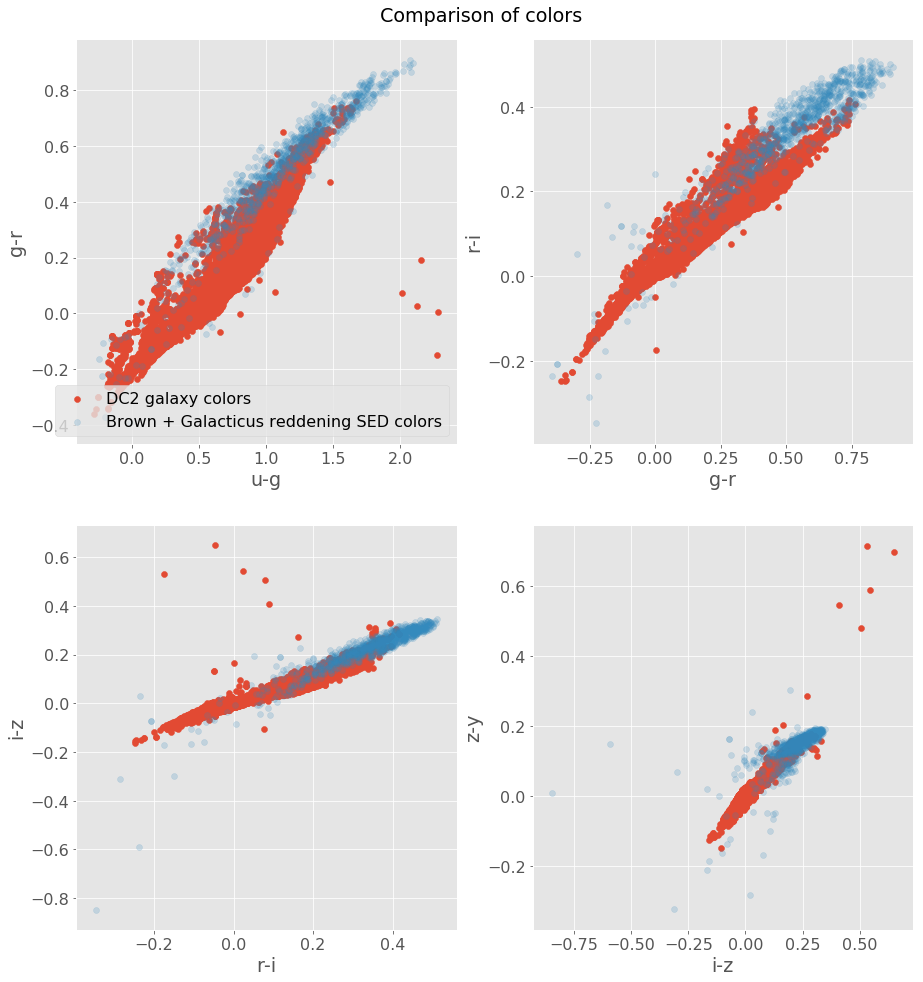

In [19]:
fig = plt.figure(figsize=(15,15))
color_labels = ['u-g', 'g-r', 'r-i', 'i-z', 'z-y']
for i in range(4):
    col_0 = i
    col_1 = i+1
    fig.add_subplot(2,2,i+1)
    plt.scatter(lsst_dc2_colors[:,col_0], lsst_dc2_colors[:,col_1], label='DC2 galaxy colors')
    plt.scatter(lsst_template_colors[:,col_0], lsst_template_colors[:,col_1], label='Brown + Galacticus reddening SED colors',alpha=0.2)
    plt.xlabel(color_labels[i])
    plt.ylabel(color_labels[i+1])
    if i == 0:
        plt.legend(loc=4)
plt.suptitle('Comparison of colors')
plt.subplots_adjust(top=0.95)
plt.savefig("galacticus_reddened_colors.jpg",fmt="jpg")

### Run the Gaussian Process method from ESP in the color space to generate new templates.

What we are doing below is fitting a Gaussian process for the PCA coefficients of the templates to their locations in the LSST color space. Then for every cosmoDC2 color we are predicting PCA cofficients for those locations in color space. Using these PCA coefficients we then reconstruct a spectrum for that color location and recalculate the color of the new "template". Below we compare how well the extrapolated template reproduces the input colors at that location.

In [20]:
gp_obj = esp.gaussianProcessEstimate(new_pca_obj, lsst_bandpass_dict, lsst_dc2_colors)

In [21]:
gp_kernel = gp_obj.define_kernel('exp', 1.0e-3, 1.0e-3, n_dim=len(lsst_dc2_colors[0]))

In [22]:
gp_spec = gp_obj.gp_predict(gp_kernel, opt_bandpass_dict=lsst_bandpass_dict)

In [23]:
lsst_gp_colors = gp_spec.calc_colors(lsst_bandpass_dict, 10)

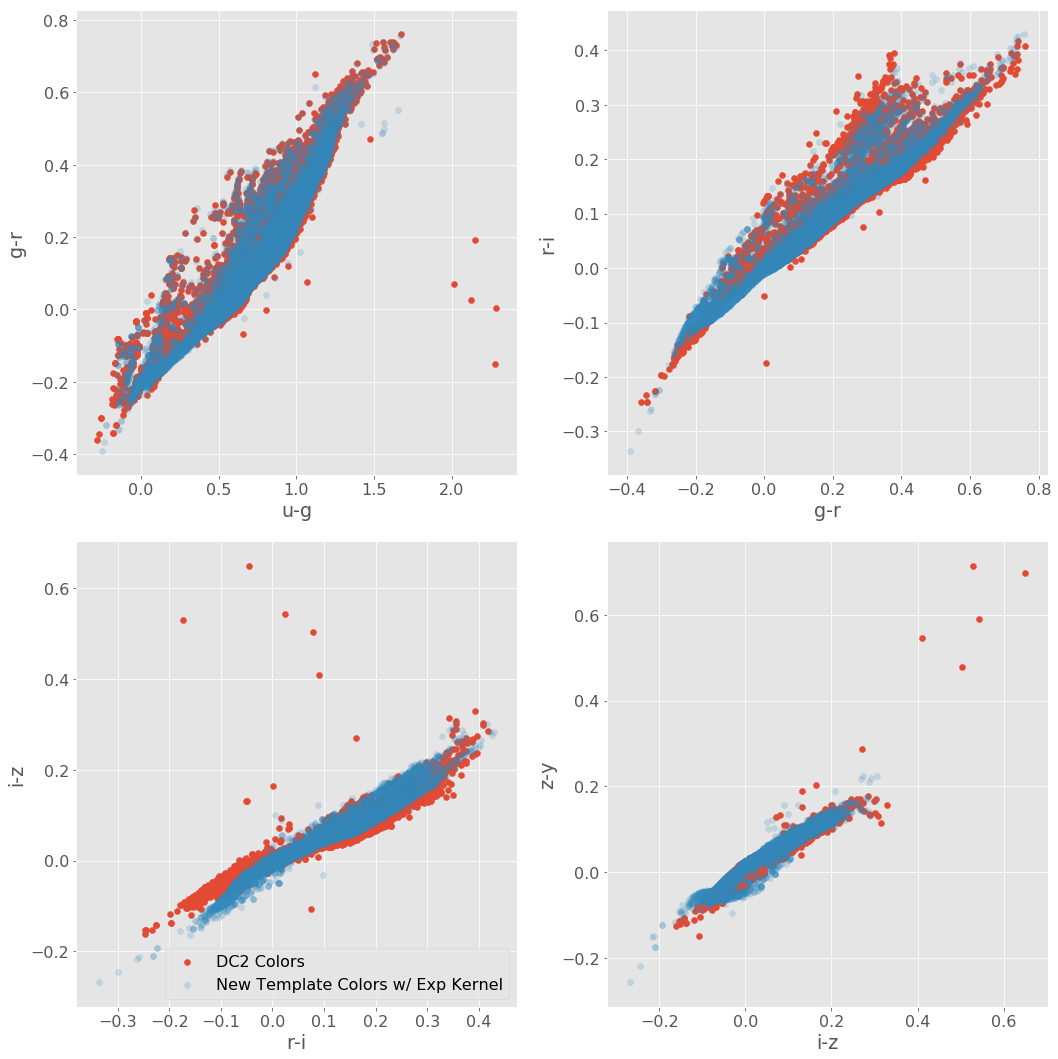

In [24]:
fig = plt.figure(figsize=(15,15))
for i in range(4):
    fig.add_subplot(2,2,i+1)
    plt.scatter(lsst_dc2_colors[:,i], lsst_dc2_colors[:,i+1], label='DC2 Colors')
    plt.scatter(lsst_gp_colors[:,i], lsst_gp_colors[:,i+1], alpha=0.2, label='New Template Colors w/ Exp Kernel')
    #plt.scatter(lsst_template_colors[:,i], lsst_template_colors[:,i+1], label='(Brown + 2 Blue) SED colors')
    plt.xlabel(color_labels[i])
    plt.ylabel(color_labels[i+1])
    if i == 2:
        plt.legend()
plt.tight_layout()
plt.savefig("galacticus_reddened_GP.jpg",fmt="jpg")

Compare how closely we are able to reconstruct the colors for each cosmoDC2 galaxy with a new template.

In [ ]:
#m32_gp_lsst = np.sqrt(np.sum(np.square(lsst_gp_colors - lsst_dc2_colors), axis=1))

In [ ]:
#m52_gp_lsst = np.sqrt(np.sum(np.square(lsst_gp_colors - lsst_dc2_colors), axis=1))

In [ ]:
#sq_exp_gp_lsst = np.sqrt(np.sum(np.square(lsst_gp_colors - lsst_dc2_colors), axis=1))

In [25]:
exp_gp_lsst = np.sqrt(np.sum(np.square(lsst_gp_colors - lsst_dc2_colors), axis=1))

Text(0,0.5,'Count')

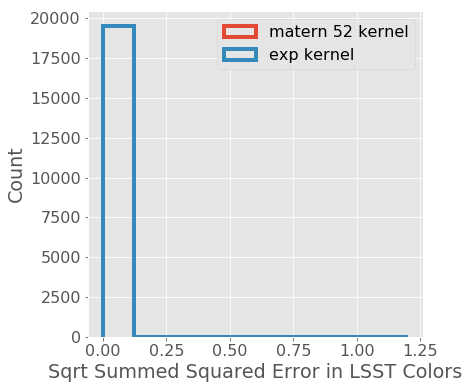

In [27]:
fig = plt.figure(figsize=(6,6))
n, bins, _ = plt.hist(exp_gp_lsst, histtype='step', label='matern 52 kernel', lw=4)
plt.hist(exp_gp_lsst, bins=bins, histtype='step', label='exp kernel', lw=4)
#plt.hist(m32_gp_lsst, bins=bins, histtype='step', label='matern 32 kernel', lw=4, range=(0, 2.5))
#plt.hist(sq_exp_gp_lsst, bins=bins, histtype='step', label='sq exp kernel', lw=4)
plt.legend()
plt.xlabel('Sqrt Summed Squared Error in LSST Colors')
plt.ylabel('Count')

In [28]:
np.exp(gp_spec.params)

array([[5.04741819e-04, 4.58222408e+02],
       [1.03575518e-04, 1.24484078e+02],
       [1.75559370e-05, 3.63158125e+01],
       [1.41109583e-05, 5.86201103e+02],
       [2.36999561e-05, 1.22462006e+03],
       [5.40969512e-05, 2.27362151e+03],
       [1.71323323e-05, 1.96156177e+03],
       [1.03970857e-05, 1.44037718e+03],
       [1.27966883e-06, 1.67311143e+01],
       [3.98971722e-06, 6.24315577e+02]])

It seems that we should use the Exponential kernel to create our templates.

### Pick the new templates that most accurately recreate the input colors to use as a new set of templates.

First we will find the 5000 new templates that best recreate the input colors from cosmoDC2 galaxies.

In [29]:
min_err_idx = np.argsort(exp_gp_lsst)
min_err_idx = min_err_idx[:50000]

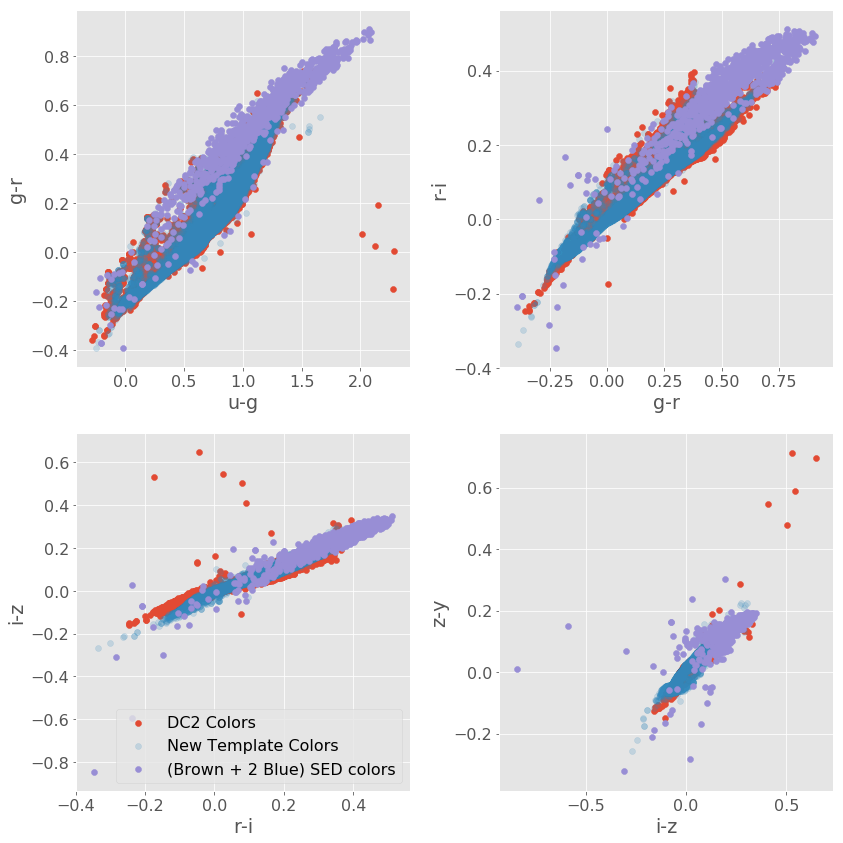

In [30]:
fig = plt.figure(figsize=(12,12))
for i in range(4):
    fig.add_subplot(2,2,i+1)
    plt.scatter(lsst_dc2_colors[:,i], lsst_dc2_colors[:,i+1], label='DC2 Colors')
    plt.scatter(lsst_gp_colors[min_err_idx,i], lsst_gp_colors[min_err_idx,i+1], alpha=0.2, label='New Template Colors')
    plt.scatter(lsst_template_colors[:,i], lsst_template_colors[:,i+1], label='(Brown + 2 Blue) SED colors')
    plt.xlabel(color_labels[i])
    plt.ylabel(color_labels[i+1])
    if i == 2:
        plt.legend()
plt.tight_layout()

Next we will cluster these high-grade templates into 50 clusters in color space to get a good spread of new locations for new templates and then randomly choose one template from each cluster to be the point at which we will create a new template.

In [31]:
rand_state = np.random.RandomState(3213)
kmeans = KMeans(n_clusters = 100, random_state=rand_state).fit(lsst_gp_colors[min_err_idx])

In [32]:
new_template_idx = []
for cluster_num in range(100):
    cluster_idx = np.where(kmeans.labels_ == cluster_num)[0]
    new_template_idx.append(rand_state.choice(min_err_idx[cluster_idx]))

Now we randomly choose one template from each cluster and use the PCA coefficients for these points in color space to generate a new set of 100 templates to complement the (Brown + BC03 Blue) templates.

In [33]:
new_templates = gp_spec.reconstruct_spectra(10)[new_template_idx]

Text(0.5,1,'100 new templates')

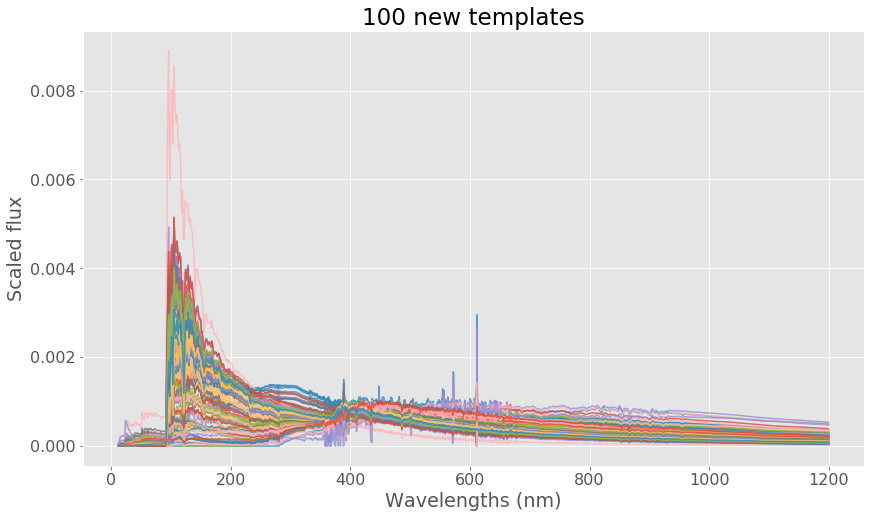

In [35]:
fig = plt.figure(figsize=(14, 8))
for i in range(100):
    plt.plot(new_pca_obj.wavelengths, new_templates[i], alpha=0.8)
plt.xlabel('Wavelengths (nm)')
plt.ylabel('Scaled flux')
plt.title('100 new templates')

We take these new templates and see where they are in color space compared to DC2 and the (Brown + 2 Blue) templates

In [36]:
lsst_new_template_colors = []
for sed_template in new_templates:
    test_sed = Sed()
    test_sed.setSED(wavelen=new_pca_obj.wavelengths, flambda=sed_template)
    maglist = lsst_bandpass_dict.magListForSed(test_sed)
    colors_list = maglist[:-1] - maglist[1:]
    lsst_new_template_colors.append(colors_list)

In [37]:
lsst_new_template_colors = np.array(lsst_new_template_colors)

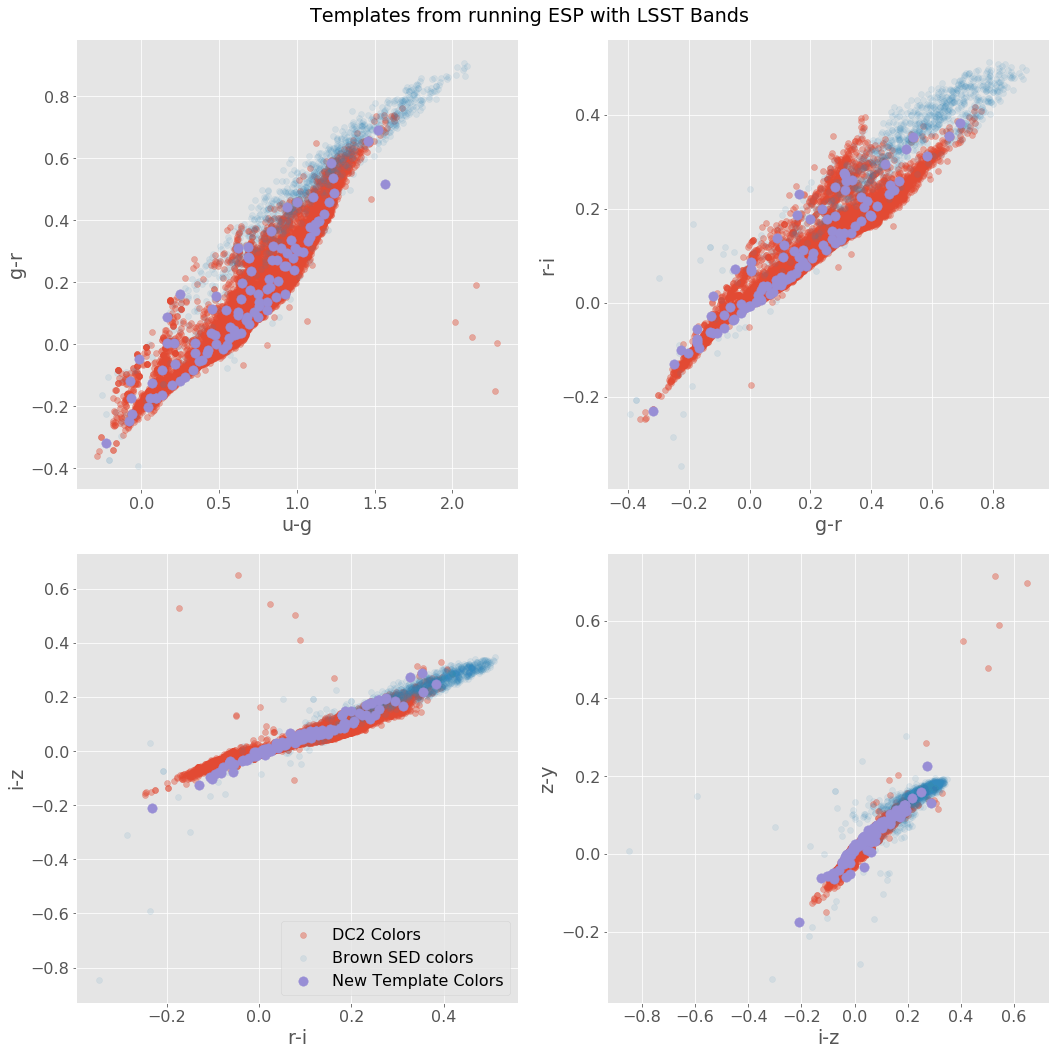

In [38]:
color_labels = ['u-g', 'g-r', 'r-i', 'i-z', 'z-y']

fig = plt.figure(figsize=(15,15))
for i in range(4):
    fig.add_subplot(2,2,i+1)
    plt.scatter(lsst_dc2_colors[:,i], lsst_dc2_colors[:,i+1], label='DC2 Colors', alpha=0.4)
    plt.scatter(lsst_template_colors[:,i], lsst_template_colors[:,i+1], alpha=0.1,label='Brown SED colors')
    plt.scatter(lsst_new_template_colors[:,i], lsst_new_template_colors[:,i+1], label='New Template Colors', s=88)
    plt.xlabel(color_labels[i])
    plt.ylabel(color_labels[i+1])
    if i == 2:
        plt.legend()
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.suptitle('Templates from running ESP with LSST Bands')
plt.savefig("new_templates.jpg",fmt="jpg")

Finally, we write the templates to file.

In [39]:
### To write the new templates to file:
# (Changed to be written in angstroms to be consistent with Brown templates given)
template_folder = 'new_templates_wBC03_v4'
os.mkdir(template_folder)
sed_names = []
spec_on = 0
for sed_obj in new_templates:
    with open(os.path.join(template_folder, '%i.sed' % spec_on), 'w') as f:
        f.write('# Wavelength(angstrom)  Flambda(ergs/cm^s/s/angstrom)\n')
        for line_idx in range(len(new_pca_obj.wavelengths)):
            print(10.*new_pca_obj.wavelengths[line_idx], 0.1*sed_obj[line_idx], file=f)
    spec_on += 1